In [1]:
# Import necessory modules
%matplotlib inline
import pandas as pd
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler
from torch import Tensor
from torch.nn import Linear
from torch.nn import Sigmoid
from torch.nn import Module
from torch.nn.init import xavier_uniform_
from torch.nn import MSELoss
from torch.optim import SGD
import math
from torch.optim.lr_scheduler import MultiStepLR
# For reproduce the result

torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

In [2]:
class DR(Dataset):
    def __init__(self, csv_path):
        df = pd.read_csv(csv_path,encoding= 'unicode_escape')
        self.X=df.iloc[:,:-1].values
        self.y=df.iloc[:,-1].values
        self.X_scaler=MinMaxScaler()
        self.y_scaler=MinMaxScaler()
        self.X=self.X_scaler.fit_transform(self.X)
        self.y=self.y.reshape(len(self.y),1)
        self.y=self.y_scaler.fit_transform(self.y)
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self,idx):
        feature=torch.tensor(self.X[idx],dtype=torch.float32)
        label=torch.tensor(self.y[idx],dtype=torch.float32)
        return feature,label

In [3]:
class MLP2(nn.Module):
    def __init__(self,input_ch=30,first_layers=256,second_layers=128,third_layers=64,
                 activation=nn.Sigmoid(),output_act=nn.Tanh()):
        super(MLP2,self).__init__()
        self.model=nn.Sequential(nn.Linear(input_ch,first_layers),
                                 activation,
                                 nn.Linear(first_layers,second_layers),
                                 activation,
                                 nn.Linear(second_layers,third_layers),
                                 activation,
                                 nn.Linear(third_layers,1)
                                )

        self.output_act=output_act
        
    def forward(self,X):
        X=self.model(X)
        X=self.output_act(X)
        return X

In [4]:
def relative_root_mean_squared_error(true, pred):
    num = np.sum(np.square(true - pred))
    den = np.sum(np.square(pred))
    squared_error = num/den
    rrmse_loss = np.sqrt(squared_error)
    return rrmse_loss

def relative_root_mean_squared_error2(true, pred):
    num = np.sum(np.square(true - pred))
    mse_loss = num/true.size
    den = np.sum(np.square(pred))
    squared_error = mse_loss/den
    rrmse_loss = np.sqrt(squared_error)
    return rrmse_loss

def relative_root_mean_squared_error3(true, pred):
    num = np.sum(np.square(true - pred))
    mse_loss = num/true.size
    den = np.sum(np.square(true))
    squared_error = mse_loss/den
    rrmse_loss = np.sqrt(squared_error)
    return rrmse_loss

def relative_root_mean_squared_error4(true, pred):
    num = np.sum(np.square(true - pred))
    mse_loss = num/true.size
    mse_loss_root = np.sqrt(mse_loss)
    den = np.sum(true)/true.size
    rrmse_loss = (mse_loss_root/den)
    return rrmse_loss

def root_mean_squared_error(true, pred):
    squared_error = np.square(true - pred) 
    sum_squared_error = np.sum(squared_error)
    rmse_loss = np.sqrt(sum_squared_error / true.size)
    return rmse_loss

def root_mean_squared_relative_error(true, pred):
    num = np.sum(np.square((true - pred) / true))
    rmse = num/true.size
    rmsre_loss = np.sqrt(rmse)
    return rmsre_loss

def relative_squared_error(true, pred):
    true_mean = np.mean(true)
    squared_error_num = np.sum(np.square(true - pred))
    squared_error_den = np.sum(np.square(true - true_mean))
    rse_loss = squared_error_num / squared_error_den
    return rse_loss

def root_relative_squared_error(true, pred):
    true_mean = np.mean(true)
    squared_error_num = np.sum(np.square(true - pred))
    squared_error_den = np.sum(np.square(true - true_mean))
    rse_loss = squared_error_num / squared_error_den
    rrse_lose = np.sqrt(rse_loss)
    return rrse_lose

In [5]:
train_RoofDR=DR('VODRoofDRtrain.csv')
val_RoofDR=DR('VODRoofDRval.csv')

In [6]:
train_RoofDR_dl=DataLoader(train_RoofDR,batch_size=64,shuffle=True)
val_RoofDR_dl=DataLoader(val_RoofDR,batch_size=64,shuffle=False)

In [7]:
models={"Model4":MLP2(input_ch=4,first_layers=32768,second_layers=64,third_layers=8,activation=nn.Tanh(),output_act=nn.Tanh())}

In [8]:
epoch = 1000
#epoch = 3000
learning_rate = 0.01
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
models['Model4'].to(device)

criterion = nn.MSELoss().to(device)
result={}

for name,model in models.items():
    optimizer=optim.SGD(model.parameters(),lr=learning_rate,momentum=0.9)
    pbar=tqdm(range(epoch))
    result[name]={"Training Loss":[],"Validation Loss":[]}
    for i in pbar:
        training_loss=0
        val_loss=0
        pred_list=0
        for inputs,label in train_RoofDR_dl:

            pred=model(inputs.to(device))
            loss=criterion(pred,label.to(device))
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            loss = loss.cpu()
            
            training_loss+=loss.detach().numpy()
            
        for inputs,label in val_RoofDR_dl:
            with torch.no_grad():
                
                pred=model(inputs.to(device))
                loss=criterion(pred,label.to(device))
                
                loss = loss.cpu()
                
                val_loss+=loss.numpy()
                
        result[name]["Training Loss"].append(training_loss/len(train_RoofDR_dl))
        result[name]["Validation Loss"].append(val_loss/len(val_RoofDR_dl))
        
#    torch.save(model.state_dict(),"VODRoofDR.pth")

  0%|          | 0/1000 [00:00<?, ?it/s]

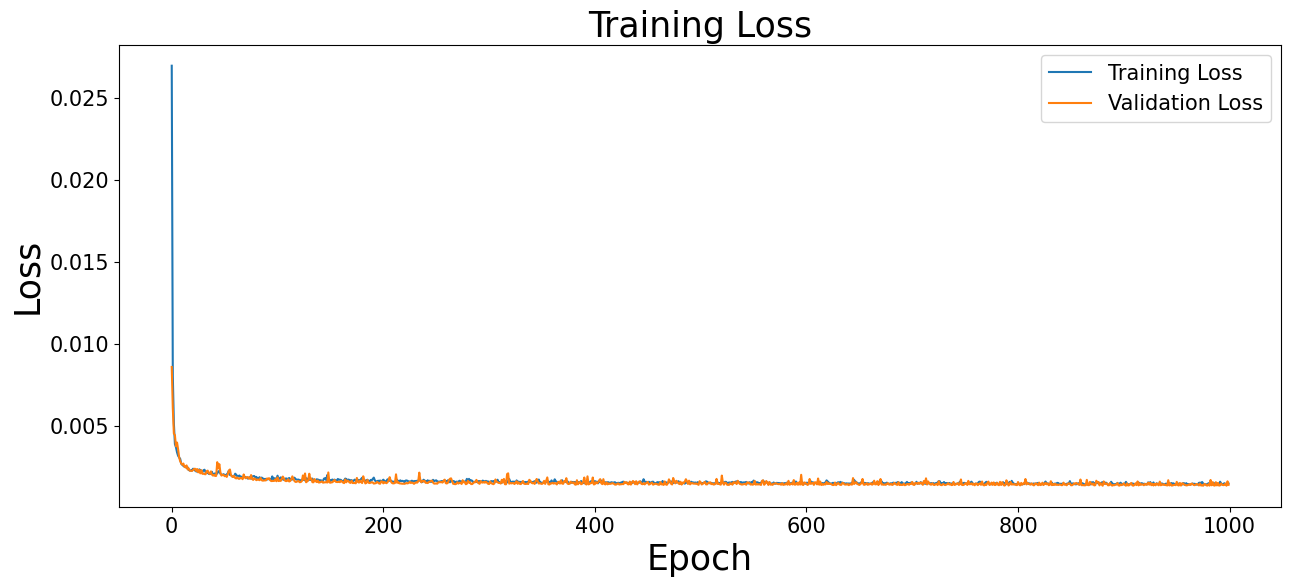

In [9]:
plt.figure(figsize=(15,6))
plt.title(f"Training Loss", fontdict={'size': 25})
plt.xlabel("Epoch", fontdict={'size': 25})
plt.ylabel("Loss", fontdict={'size': 25})
plt.tick_params(axis='x', labelsize= 15)
plt.tick_params(axis='y', labelsize= 15)
plt.plot(range(len(result[name][f"Training Loss"])),result[name][f"Training Loss"],label=f"Training Loss")
plt.plot(range(len(result[name][f"Validation Loss"])),result[name][f"Validation Loss"],label=f"Validation Loss")
plt.legend(prop={'size': 15})
#plt.savefig('comparefigure/VODRoofDRloss.jpg')
plt.show()

In [7]:
from sklearn.metrics import mean_squared_error
models={"Model4":MLP2(input_ch=4,first_layers=32768,second_layers=64,third_layers=8,activation=nn.Tanh(),output_act=nn.Tanh())}
test_ds=DR('best/VODRoofDRtest.csv')
#test_ds=DR('shahsdata/VODRoofDR.csv')
test_dl=DataLoader(test_ds,batch_size=len(test_ds),shuffle=False)
output={}
for name,model in models.items():
    for X,y in test_dl:
        model.load_state_dict(torch.load("VODRoofDR.pth"))
        model.eval()
        with torch.no_grad():
            pred=model(X)
            output["Target"]=test_ds.y_scaler.inverse_transform(y).squeeze()
            output[name]=test_ds.y_scaler.inverse_transform(pred).squeeze()
#        print(f"Relative Root Mean Squared Error ({name}): ",relative_root_mean_squared_error(output["Target"],output[name]))
#        print(f"Relative Root Mean Squared Error2 ({name}): ",relative_root_mean_squared_error2(output["Target"],output[name]))
#        print(f"Relative Root Mean Squared Error3 ({name}): ",relative_root_mean_squared_error3(output["Target"],output[name]))
#        print(f"Relative Root Mean Squared Error4 ({name}): ",relative_root_mean_squared_error4(output["Target"],output[name]))
        print(f"Mean Squared Error ({name}): ",mean_squared_error(output["Target"],output[name]))

Mean Squared Error (Model4):  0.27087969894170766


In [8]:
out=pd.DataFrame(output)
out.to_csv("VODRoofDRresult.csv")